**NEXT STEPS**:
- (Hacer formulas para las visualizaciones y tests repetitivos)
- Entrenar modelo, iterar para buscar el máximo score, SVM, random forest
- Hacer predicciones 
- Comentar bien el código
- interactive viz con ipywidgets
- Hacer readme y presentación


**Dudas**: 
- si en el análisis estadístico vemos que hay algunas variables que tienen un efecto significativo en la media de attrition, cogemos solo esas?

COMENTARIOS ALBERTO:
- antes de hacer el modelo pasar toda la matriz por standardscaler
- todas las variables categoricas tienen que estar en 0s y 1s
- pasar categoricas a 0 y 1
- si hay más de 2 categorías hacer one hot encoding
- pip install category_encoders: mejor que get dummies para proyecto final. Encoding por variables respecto a depto
- no hace falta normalizar los datos de distribución no normal, basta con hacer un test no paramétrico

# Importing libraries and data

In [205]:
from scipy import stats

import numpy as np
import pandas as pd

import seaborn as sns
import cufflinks as cf
import plotly.express as px
from ipywidgets import interact
import matplotlib.pyplot as plt

In [620]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from xgboost import XGBClassifier

In [313]:
plt.rcParams["figure.figsize"] = (10,6)

In [208]:
pd.options.plotting.backend = 'plotly'

In [209]:
df = pd.read_csv('project-public-clean.csv')

In [210]:
df.set_index('EEID', inplace=True)

In [211]:
df.head()

,Status,Age,Gender,Education Level,Hire Date,Termination Date,Termination Type,Termination Reason,Job Information: Date,Division,...,Supervisor EID,Pay rate,Pay rate - Currency code,Compensation Change Reason,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,Undergraduate degree (Grado),2019-08-19,2019-09-30,Involuntary,End of contract,2019-08-19,People,...,1,6047.0,EUR,Reduce/Increase Working hours,N,Unknown,No,"1 month, 11 days",0,1
468,Inactive,29,Male,Unknown,2016-07-05,2017-03-30,Involuntary,End of contract,2016-07-05,Engineering,...,234,6144.0,EUR,Unknown,N,Unknown,No,"8 months, 25 days",0,8
458,Inactive,27,Male,Unknown,2016-09-05,2017-01-26,Involuntary,End of contract,2016-09-05,Engineering,...,0,6144.0,EUR,Unknown,N,Unknown,No,"4 months, 21 days",0,4
379,Inactive,25,Male,Undergraduate degree (Grado),2017-10-23,2018-08-28,Involuntary,End of contract,2017-10-23,Engineering,...,0,6144.0,EUR,New hire,N,Unknown,No,"10 months, 5 days",0,10
492,Inactive,58,Female,Unknown,2017-09-13,2017-09-29,Involuntary,End of contract,2017-09-13,People,...,0,7200.0,EUR,Unknown,N,Unknown,No,16 days,0,0


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 343 to 721
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Status                      607 non-null    object 
 1   Age                         607 non-null    int64  
 2   Gender                      607 non-null    object 
 3   Education Level             607 non-null    object 
 4   Hire Date                   607 non-null    object 
 5   Termination Date            258 non-null    object 
 6   Termination Type            258 non-null    object 
 7   Termination Reason          254 non-null    object 
 8   Job Information: Date       607 non-null    object 
 9   Division                    607 non-null    object 
 10  Department                  607 non-null    object 
 11  Supervisor EID              607 non-null    int64  
 12  Pay rate                    607 non-null    float64
 13  Pay rate - Currency code    607 n

# Data wrangling

In [213]:
df['Attrition'] = pd.get_dummies(df['Termination Type'], drop_first=True)

In [214]:
df['Pay rate EUR'] = np.where(df['Pay rate - Currency code'] == 'USD', df['Pay rate'] * 0.82 * (1-0.38), df['Pay rate'])
# también funcionaría con lo siguiente, pero me queda mas claro usando np.where: df.apply(lambda x: (x['Pay rate'] * 0.82) if x['Pay rate - Currency code'] == 'USD' else x['Pay rate'], axis=1)

In [215]:
df['Pay rate EUR'] = np.where(df['Pay rate - Currency code'] == 'GBP', df['Pay rate'] * 1.16 * (1-0.41), df['Pay rate EUR'])

In [216]:
# Para comprobar que está bien:
df[['Pay rate', 'Pay rate - Currency code', 'Pay rate EUR']][df['Pay rate - Currency code'] == 'GBP']

,Pay rate,Pay rate - Currency code,Pay rate EUR
EEID,,,
700,41600.0,GBP,28471.04
697,44000.0,GBP,30113.60
779,44000.0,GBP,30113.60
698,56000.0,GBP,38326.40
774,68000.0,GBP,46539.20
757,68000.0,GBP,46539.20
731,96000.0,GBP,65702.40
161,99200.0,GBP,67892.48


In [217]:
# Location
df['Location'] = df.apply(lambda x: 'North America' if x['Pay rate - Currency code'] == 'USD' else 'Europe', axis=1)

In [218]:
# Reordenamos las columnas para que quede más claro:
df = df[['Status', 'Age', 'Gender', 'Education Level', 'Hire Date', 
       'Termination Date', 'Termination Type', 'Termination Reason', 'Attrition',
       'Job Information: Date', 'Location', 'Division', 'Department', 'Supervisor EID',
       'Pay rate', 'Pay rate - Currency code', 'Pay rate EUR', 'Compensation Change Reason',
       'Stock Options', 'Level', 'Is Supervisor', 'Length of service',
       'Length of service: Years', 'Length of service: Months']]

In [219]:
df['Age bracket'] = pd.cut(df['Age'], bins = [18, 25, 30, 35, 40, 45, 50, 55], labels = [i for i in range(7)])

In [220]:
df['Division'] = df['Division'].apply(lambda x: 'People & Home' if 'People' in x or 'Home' in x else x)

In [221]:
df['Division'] = df['Division'].apply(lambda x: 'Finance & Legal' if 'Finance' in x else x)

In [222]:
df['Division'] = df['Division'].apply(lambda x: 'Leadership' if 'Founders' in x else x)

In [223]:
df.groupby('Division').sum()['Attrition'] / df.groupby('Division').count()['Attrition']

Division
Business Development    0.294118
Customer Success        0.233766
Data & Analytics        0.228070
Design                  0.272727
Engineering             0.382775
Finance & Legal         0.272727
Leadership              0.333333
Marketing               0.327586
People & Home           0.272727
Product                 0.400000
R&D                     0.000000
Security                0.000000
Strategy                0.000000
Unknown                 0.333333
Name: Attrition, dtype: float64

In [224]:
df = pd.concat([df, pd.get_dummies(df['Gender'], drop_first=True)], axis=1)

In [225]:
df.drop(df.loc[df['Not Specified'] == 1].index, inplace=True)

In [226]:
df.drop(df.loc[df['Unknown'] == 1].index, inplace=True)

In [227]:
df = df.drop(columns=['Male', 'Not Specified', 'Unknown'])

In [228]:
df.drop('Education Level', axis=1, inplace=True)

In [229]:
df['North America'] = pd.get_dummies(df['Location'], drop_first=True)

In [230]:
df.Division.value_counts()

Engineering             207
Customer Success         76
Marketing                58
Data & Analytics         57
People & Home            54
Design                   44
Product                  40
Finance & Legal          22
Business Development     17
Strategy                 11
Security                  8
Leadership                3
Unknown                   3
R&D                       3
Name: Division, dtype: int64

In [231]:
df['Has_stock'] = pd.get_dummies(df['Stock Options'], drop_first=True)

In [232]:
df['Level'].value_counts()
# muchos valores unknown!

E3         157
E2         135
Unknown     68
M1          44
L2          43
L3          30
M3          28
M2          21
E4          20
E1          20
L1           7
C-Level      7
E0           6
L4           5
M4           5
E5           2
L0           2
L5           1
E6           1
M0           1
Name: Level, dtype: int64

In [233]:
df['Level'] = df['Level'].replace('(.*)[^EM](?=\d)','E', regex=True)

In [234]:
df['Level'] = df['Level'].replace('M0', 'M1')

In [235]:
e_levels = sorted([level for level, count in df['Level'].value_counts().iteritems() if 'E' in level])

In [236]:
m_levels = sorted([level for level, count in df['Level'].value_counts().iteritems() if 'M' in level])

In [237]:
sorted_levels = ['Unknown'] + e_levels + m_levels + ['C-Level']

In [238]:
dict_levels = {level:order for level, order in zip(sorted_levels, range(len(sorted_levels)))}
dict_levels

{'Unknown': 0,
 'E0': 1,
 'E1': 2,
 'E2': 3,
 'E3': 4,
 'E4': 5,
 'E5': 6,
 'E6': 7,
 'M1': 8,
 'M2': 9,
 'M3': 10,
 'M4': 11,
 'C-Level': 12}

In [239]:
df['Level_ordinal'] = df['Level'].map(dict_levels)

In [240]:
df.head()

,Status,Age,Gender,Hire Date,Termination Date,Termination Type,Termination Reason,Attrition,Job Information: Date,Location,...,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months,Age bracket,North America,Has_stock,Level_ordinal
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,2019-08-19,2019-09-30,Involuntary,End of contract,0,2019-08-19,Europe,...,N,Unknown,No,"1 month, 11 days",0,1,1,0,0,0
468,Inactive,29,Male,2016-07-05,2017-03-30,Involuntary,End of contract,0,2016-07-05,Europe,...,N,Unknown,No,"8 months, 25 days",0,8,1,0,0,0
458,Inactive,27,Male,2016-09-05,2017-01-26,Involuntary,End of contract,0,2016-09-05,Europe,...,N,Unknown,No,"4 months, 21 days",0,4,1,0,0,0
379,Inactive,25,Male,2017-10-23,2018-08-28,Involuntary,End of contract,0,2017-10-23,Europe,...,N,Unknown,No,"10 months, 5 days",0,10,0,0,0,0
492,Inactive,58,Female,2017-09-13,2017-09-29,Involuntary,End of contract,0,2017-09-13,Europe,...,N,Unknown,No,16 days,0,0,NaN,0,0,0


In [241]:
df.columns

Index(['Status', 'Age', 'Gender', 'Hire Date', 'Termination Date',
       'Termination Type', 'Termination Reason', 'Attrition',
       'Job Information: Date', 'Location', 'Division', 'Department',
       'Supervisor EID', 'Pay rate', 'Pay rate - Currency code',
       'Pay rate EUR', 'Compensation Change Reason', 'Stock Options', 'Level',
       'Is Supervisor', 'Length of service', 'Length of service: Years',
       'Length of service: Months', 'Age bracket', 'North America',
       'Has_stock', 'Level_ordinal'],
      dtype='object')

In [242]:
df

,Status,Age,Gender,Hire Date,Termination Date,Termination Type,Termination Reason,Attrition,Job Information: Date,Location,...,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months,Age bracket,North America,Has_stock,Level_ordinal
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,2019-08-19,2019-09-30,Involuntary,End of contract,0,2019-08-19,Europe,...,N,Unknown,No,"1 month, 11 days",0,1,1,0,0,0
468,Inactive,29,Male,2016-07-05,2017-03-30,Involuntary,End of contract,0,2016-07-05,Europe,...,N,Unknown,No,"8 months, 25 days",0,8,1,0,0,0
458,Inactive,27,Male,2016-09-05,2017-01-26,Involuntary,End of contract,0,2016-09-05,Europe,...,N,Unknown,No,"4 months, 21 days",0,4,1,0,0,0
379,Inactive,25,Male,2017-10-23,2018-08-28,Involuntary,End of contract,0,2017-10-23,Europe,...,N,Unknown,No,"10 months, 5 days",0,10,0,0,0,0
492,Inactive,58,Female,2017-09-13,2017-09-29,Involuntary,End of contract,0,2017-09-13,Europe,...,N,Unknown,No,16 days,0,0,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,Inactive,35,Female,2018-08-20,2018-11-09,Voluntary,NaN,1,2018-08-20,North America,...,N,Unknown,No,"2 months, 20 days",0,2,2,1,0,0
760,Active,47,Female,2021-04-21,NaN,NaN,NaN,0,2021-04-21,North America,...,N,M3,Yes,"1 month, 7 days",0,1,5,1,0,10
773,Active,40,Male,2021-05-17,NaN,NaN,NaN,0,2021-05-17,North America,...,N,M4,No,11 days,0,0,3,1,0,11


# Exploratory Data Analysis (Shapiro tests, plots)

Variable que queremos predecir: **Attrition**

Variables que nos interesan: 

**Numéricas:**
- Age
- Pay rate EUR
- Lenghts of service (months)

**Categóricas:**
- Gender
- Location
- Division
- Stock Options
- Is Supervisor
- Age bracket

**Columnas encoded**: 'Female', 'North America', 'Business Development', 'Customer Success',
       'Data & Analytics', 'Design', 'Engineering', 'Finance & Legal',
       'Leadership', 'Marketing', 'People & Home', 'Product', 'R&D',
       'Security', 'Strategy', 'Has_stock', 'C-Level', 'E0', 'E1', 'E2', 'E3',
       'E4', 'E5', 'E6', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'M0', 'M1', 'M2',
       'M3', 'M4', 'Unknown_level', 'Is_Supervisor_enc'


In [243]:
cols_to_drop = ['Hire Date', 'Termination Date', 'Termination Type', 'Termination Reason', 'Job Information: Date',
                'Department', 'Supervisor EID', 'Pay rate', 'Pay rate - Currency code','Compensation Change Reason', 'Length of service', 
                'Length of service: Years', 'Age bracket', 'Is Supervisor']
# borro las columnas que no vamos a usar

In [244]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [245]:
df.columns

Index(['Status', 'Age', 'Gender', 'Attrition', 'Location', 'Division',
       'Pay rate EUR', 'Stock Options', 'Level', 'Length of service: Months',
       'North America', 'Has_stock', 'Level_ordinal'],
      dtype='object')

In [246]:
# columnas encoded: df.columns[-37:]

## Numerical variables

In [247]:
stats.shapiro(df['Age'])

ShapiroResult(statistic=0.9524832963943481, pvalue=5.08773687242503e-13)

In [248]:
df['Age'].iplot('hist')

In [249]:
stats.shapiro(df['Pay rate EUR'])

ShapiroResult(statistic=0.8029524683952332, pvalue=1.9286060625635608e-26)

In [250]:
df['Pay rate EUR'].iplot('hist')

In [251]:
stats.shapiro(df['Length of service: Months'])

ShapiroResult(statistic=0.8911247253417969, pvalue=3.185232462693613e-20)

In [252]:
df['Length of service: Months'].iplot('hist')

## Categorical variables

In [253]:
colors = ['red', 'blue']

In [254]:
px.bar(df['Gender'].value_counts(), color=colors, color_discrete_map="identity")

In [255]:
px.bar(df['Location'].value_counts(), color=colors, color_discrete_map="identity")

In [256]:
px.bar(df['Division'].value_counts(), color=df['Division'].value_counts(), color_discrete_map="identity")

In [257]:
px.bar(df['Stock Options'].value_counts(), color=colors, color_discrete_map="identity")

In [258]:
px.bar(df['Level'].value_counts(), color=df['Level'].value_counts())

# Hypothesis testing (Mann Whitney Test, Chi2)

## Continuous variables - Mann Whitney Test

In [259]:
not_attrition = df[df['Attrition'] == 0]
attrition = df[df['Attrition'] == 1]

### Age

In [260]:
stats.mannwhitneyu(not_attrition['Age'], attrition['Age'])
# aceptamos la H0, no hay diferencia de medias significativa en la edad

MannwhitneyuResult(statistic=38483.0, pvalue=0.44005710982192214)

### Pay rate

In [261]:
stats.mannwhitneyu(not_attrition['Pay rate EUR'], attrition['Pay rate EUR'])
# aceptamos la H0, no hay diferencia de medias significativa en el salario

MannwhitneyuResult(statistic=36708.0, pvalue=0.1470652209107165)

### Length of service

In [262]:
stats.mannwhitneyu(not_attrition['Length of service: Months'], attrition['Length of service: Months'])

MannwhitneyuResult(statistic=24907.0, pvalue=1.0770431451273054e-12)

In [263]:
df_active_and_attrition = pd.concat([df[df['Attrition'] == 1],
                                     df[(df['Status'] == 'Active')]], axis=0)
df_active_and_attrition.reset_index(inplace=True)

In [264]:
df[['Attrition', 'Length of service: Months']].pivot(columns='Attrition', values='Length of service: Months').iplot(kind='box')

In [265]:
df_active_and_attrition[['Attrition', 'Length of service: Months']].pivot(columns='Attrition', values='Length of service: Months').iplot(kind='box')
# vemos que la gente que se va voluntariamente lleva más tiempo en la empresa 

## Discrete variables - Chi2

### Gender

In [266]:
df_gender = pd.DataFrame(df.groupby('Gender').sum()['Attrition'])

In [267]:
df_gender['Not_Attrition'] = df.groupby('Gender').count()['Attrition'] - df_gender['Attrition']
df_gender

,Attrition,Not_Attrition
Gender,,
Female,65,141
Male,121,276


In [268]:
stats.chi2_contingency(df_gender)
# el p-value está muy por encima de 0.05, así que no hay diferencia entre la media de attrition por géneros. 

(0.031704036764750504,
 0.8586787813903957,
 1,
 array([[ 63.54228856, 142.45771144],
        [122.45771144, 274.54228856]]))

### Location

In [269]:
df_location = pd.DataFrame(df.groupby('Location').sum()['Attrition'])

In [270]:
df_location['Not_Attrition'] = df.groupby('Location').count()['Attrition'] - df_location['Attrition']
df_location

,Attrition,Not_Attrition
Location,,
Europe,173.0,369.0
North America,13.0,48.0


In [271]:
stats.chi2_contingency(df_location)
# el p-value está muy por encima de 0.05, así que no hay diferencia entre la media de attrition por ubicaciones. 

(2.416188171167937,
 0.12008682401316252,
 1,
 array([[167.1840796, 374.8159204],
        [ 18.8159204,  42.1840796]]))

### Division

In [272]:
df_division = pd.DataFrame(df.groupby('Division').sum()['Attrition'])

In [273]:
df_division['Not_Attrition'] = df.groupby('Division').count()['Attrition'] - df_division['Attrition']

In [274]:
df_division

,Attrition,Not_Attrition
Division,,
Business Development,5,12
Customer Success,18,58
Data & Analytics,13,44
Design,12,32
Engineering,80,127
Finance & Legal,6,16
Leadership,1,2
Marketing,19,39
People & Home,15,39


In [275]:
stats.chi2_contingency(df_division)
# p-value un poco por debajo de 0.05. 
# Rechazamos la H0 y concluimos que si hay una diferencia significativa en attrition por divisiones

(21.611397110719334,
 0.06168320826205401,
 13,
 array([[  5.24378109,  11.75621891],
        [ 23.44278607,  52.55721393],
        [ 17.58208955,  39.41791045],
        [ 13.5721393 ,  30.4278607 ],
        [ 63.85074627, 143.14925373],
        [  6.78606965,  15.21393035],
        [  0.92537313,   2.07462687],
        [ 17.89054726,  40.10945274],
        [ 16.65671642,  37.34328358],
        [ 12.33830846,  27.66169154],
        [  0.92537313,   2.07462687],
        [  2.46766169,   5.53233831],
        [  3.39303483,   7.60696517],
        [  0.92537313,   2.07462687]]))

In [276]:
df_division['Proportion'] = df_division['Attrition'] / (df_division['Attrition'] + df_division['Not_Attrition'])

In [277]:
px.bar(df_division, x=df_division.index, y='Proportion', color='Proportion').update_xaxes(categoryorder='total descending')
# product y Engineering son las divsiones con más attrition y Strategy, Security y R&D las que tienen menos

### Stock options

In [278]:
df_stock = pd.DataFrame(df.groupby('Stock Options').sum()['Attrition'])

In [279]:
df_stock['Not_Attrition'] = df.groupby('Stock Options').count()['Attrition'] - df_stock['Attrition']
df_stock

,Attrition,Not_Attrition
Stock Options,,
N,31.0,261.0
Y,155.0,156.0


In [280]:
stats.chi2_contingency(df_stock)
# el p-value está muy por debajo de 0.05, así que sí que hay diferencia entre la media de attrition según si los empleados 
# tienen acciones o no. 

(106.78370375707111,
 4.965065284543626e-25,
 1,
 array([[ 90.06965174, 201.93034826],
        [ 95.93034826, 215.06965174]]))

In [281]:
df_stock['Proportion'] = df_stock['Attrition'] / (df_stock['Attrition'] + df_stock['Not_Attrition'])

In [282]:
px.bar(df_stock, x=df_stock.index, y='Proportion', color='Proportion').update_xaxes(categoryorder='total descending')
# vemos que los empleados que tienen acciones tienen más tendencia a irse. 
# esto no es cierto, lo que pasa en realidad es que los primeros empleados recibieron stock 
# y la mayoría ya se han ido, pero el stock no es la causa. 
# Eliminamos esta variable del df para que no introduzca ruido. 

In [283]:
df.drop(columns=['Has_stock','Stock Options'], inplace=True)

### Level

In [284]:
df_level = pd.DataFrame(df.groupby('Level').sum()['Attrition'])

In [285]:
df_level['Not_Attrition'] = df.groupby('Level').count()['Attrition'] - df_level['Attrition']
df_level

,Attrition,Not_Attrition
Level,,
C-Level,0,7
E0,0,8
E1,10,17
E2,53,125
E3,47,140
E4,4,21
E5,1,2
E6,0,1
M1,22,23


In [286]:
stats.chi2_contingency(df_level)
# el p-value está muy por debajo de 0.05, así que sí que hay diferencia entre la media de attrition según el nivel.

(44.515302920104446,
 1.2473086908910475e-05,
 12,
 array([[  2.15920398,   4.84079602],
        [  2.46766169,   5.53233831],
        [  8.32835821,  18.67164179],
        [ 54.90547264, 123.09452736],
        [ 57.68159204, 129.31840796],
        [  7.71144279,  17.28855721],
        [  0.92537313,   2.07462687],
        [  0.30845771,   0.69154229],
        [ 13.88059701,  31.11940299],
        [  6.47761194,  14.52238806],
        [  8.63681592,  19.36318408],
        [  1.54228856,   3.45771144],
        [ 20.97512438,  47.02487562]]))

In [287]:
df_level['Proportion'] = df_level['Attrition'] / (df_level['Attrition'] + df_level['Not_Attrition'])

In [288]:
px.bar(df_level, x=df_level.index, y='Proportion', color='Proportion').update_xaxes(categoryorder='total descending')
# vemos que los empleados con nivel Unknown se han ido en mayor proporción. 
# M1 (middle management) y E1 (empleados más junior) son los que más attrition tienen. 
# Los Managers y empleados de mayor nivel, los interns y el C-Level son los que menos attrition tienen. 

# Preprocessing

## Creating new features

### Level by attrition proportion

In [289]:
level_dict = df.groupby('Level')['Attrition'].mean().to_dict()

In [290]:
level_dict['Unknown'] = df['Attrition'].mean()

In [291]:
level_dict

{'C-Level': 0.0,
 'E0': 0.0,
 'E1': 0.37037037037037035,
 'E2': 0.29775280898876405,
 'E3': 0.25133689839572193,
 'E4': 0.16,
 'E5': 0.3333333333333333,
 'E6': 0.0,
 'M1': 0.4888888888888889,
 'M2': 0.2857142857142857,
 'M3': 0.17857142857142858,
 'M4': 0.0,
 'Unknown': 0.30845771144278605}

In [292]:
df['Level_attrition_proportion'] = df['Level'].map(level_dict)

### Division by attrition proportion

In [293]:
division_dict = df.groupby('Division')['Attrition'].mean().to_dict()
division_dict

{'Business Development': 0.29411764705882354,
 'Customer Success': 0.23684210526315788,
 'Data & Analytics': 0.22807017543859648,
 'Design': 0.2727272727272727,
 'Engineering': 0.3864734299516908,
 'Finance & Legal': 0.2727272727272727,
 'Leadership': 0.3333333333333333,
 'Marketing': 0.3275862068965517,
 'People & Home': 0.2777777777777778,
 'Product': 0.4,
 'R&D': 0.0,
 'Security': 0.0,
 'Strategy': 0.0,
 'Unknown': 0.3333333333333333}

In [294]:
df['Division_attrition_proportion'] = df['Division'].map(division_dict)
df['Division_attrition_proportion']

EEID
343    0.277778
468    0.386473
458    0.386473
379    0.386473
492    0.277778
         ...   
431    0.400000
760    0.000000
773    0.327586
725    0.327586
721    0.400000
Name: Division_attrition_proportion, Length: 603, dtype: float64

### Salary difference with mean of the same level in the same division

In [295]:
mean_division_level_salary = df.groupby(['Division', 'Level'])['Pay rate EUR'].agg(['mean']).reset_index().rename(columns={'mean' : 'Mean Pay rate EUR'})
mean_division_level_salary

,Division,Level,Mean Pay rate EUR
0,Business Development,E1,25200.000000
1,Business Development,E2,23996.480000
2,Business Development,E3,34733.080000
3,Business Development,E4,40672.000000
4,Business Development,M1,36800.000000
...,...,...,...
94,Strategy,E3,45708.666667
95,Strategy,E4,77600.000000
96,Strategy,M4,112000.000000
97,Unknown,E0,12689.664000


In [296]:
df = mean_division_level_salary.merge(df, on=['Division', 'Level'])

In [297]:
df['Pay_rate_diff'] = df['Pay rate EUR'] - df['Mean Pay rate EUR']

In [315]:
df.drop('Mean Pay rate EUR', axis=1, inplace=True)

In [316]:
df.head()

,Division,Level,Status,Age,Gender,Attrition,Location,Pay rate EUR,Length of service: Months,North America,Level_ordinal,Level_attrition_proportion,Division_attrition_proportion,Pay_rate_diff
0,Business Development,E1,Active,37,Male,0,Europe,25200.00,36,0,2,0.370370,0.294118,0.00
1,Business Development,E2,Active,40,Female,0,North America,21962.88,3,1,3,0.297753,0.294118,-2033.60
2,Business Development,E2,Inactive,25,Female,1,North America,24403.20,8,1,3,0.297753,0.294118,406.72
3,Business Development,E2,Active,44,Male,0,North America,24403.20,3,1,3,0.297753,0.294118,406.72
4,Business Development,E2,Inactive,27,Female,1,North America,24403.20,1,1,3,0.297753,0.294118,406.72


In [317]:
# reordenar columnas

## Dimensionality reduction

In [318]:
# sacar csv con solo las numéricas

In [319]:
df_num = df.select_dtypes('number')

In [320]:
df_num.columns.values

array(['Age', 'Attrition', 'Pay rate EUR', 'Length of service: Months',
       'North America', 'Level_ordinal', 'Level_attrition_proportion',
       'Division_attrition_proportion', 'Pay_rate_diff'], dtype=object)

In [324]:
reordered = ['Attrition', 'Age', 'Pay rate EUR',
       'Length of service: Months', 'North America', 'Level_ordinal',
       'Level_attrition_proportion', 'Division_attrition_proportion',
       'Pay_rate_diff']

In [325]:
df_num = df_num[reordered]

In [326]:
df_num.to_csv('typeform-encoded.csv')

See the other notebook

## Feature selection - Looking for collinearity

In the statistical analysis we have seen that the variables that have a significant influence on the mean attrition are: 'Length of service: Months', 'Division', 'Stock Options', 'Level'. 

In [327]:
#plt.rcParams["figure.figsize"] = (15,12)

<AxesSubplot:>

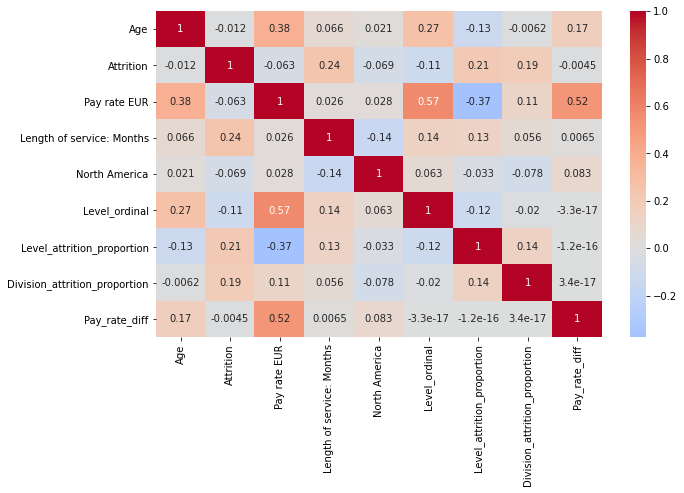

In [328]:
sns.heatmap(data=df.corr(), cmap='coolwarm', center=0, annot=True)

## Scaling

In [450]:
sc = StandardScaler()

In [495]:
data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))
data_scaled

array([[ 4.44632812e-01, -8.51583041e-01,  8.51402076e-01, ...,
         1.01541852e+00, -1.64006533e-01, -5.34924367e-17],
       [ 9.32999998e-01, -9.84473395e-01, -1.01569622e+00, ...,
         1.97445622e-01, -1.64006533e-01, -1.60989310e-01],
       [-1.50883593e+00, -8.84293300e-01, -7.32802536e-01, ...,
         1.97445622e-01, -1.64006533e-01,  3.21978620e-02],
       ...,
       [-1.83441406e+00, -1.36515776e+00, -1.12885369e+00, ...,
        -3.15647762e+00,  2.84501129e-01, -5.34924367e-17],
       [-1.50883593e+00, -1.36515776e+00, -1.01569622e+00, ...,
         3.18026923e-01,  2.84501129e-01, -6.15835410e-01],
       [ 1.19054687e-01, -7.26456447e-01,  2.85614715e-01, ...,
         3.18026923e-01,  2.84501129e-01,  6.15835410e-01]])

In [496]:
X = data_scaled
y = df_num['Attrition']

# Model training and predictions

## Lo que hicimos ayer con Javi

Note about confusion matrix: A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right). Example trying to predict 5 (positive, 1) vs other numbers (negative, 0)

![abc](Captura.PNG)

In [497]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [454]:
lr = LogisticRegression()

In [455]:
lr.fit(X_train, y_train).score(X_test, y_test)

0.71900826446281

In [456]:
y_pred = lr.fit(X_train, y_train).predict(X_test)

In [457]:
confusion_matrix(y_pred, y_test)

array([[154,  55],
       [ 13,  20]], dtype=int64)

In [458]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82       209
           1       0.27      0.61      0.37        33

    accuracy                           0.72       242
   macro avg       0.59      0.67      0.59       242
weighted avg       0.83      0.72      0.76       242



In [459]:
svc = SVC()

In [460]:
y_pred = svc.fit(X_train, y_train).predict(X_test)

In [461]:
confusion_matrix(y_pred, y_test)
# filas: real. Columnas: predicho. Orden: 0,1

array([[157,  56],
       [ 10,  19]], dtype=int64)

In [462]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83       213
           1       0.25      0.66      0.37        29

    accuracy                           0.73       242
   macro avg       0.60      0.70      0.60       242
weighted avg       0.86      0.73      0.77       242



In [463]:
svc.fit(X_train, y_train).score(X_test, y_test)

0.7272727272727273

## LogisticRegression, RandomForest, SVM, VotingClassifier

In [587]:
data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))

In [588]:
X = data_scaled
y = df_num['Attrition']

In [589]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [590]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [591]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [592]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred), '\n', confusion_matrix(y_pred, y_test))

LogisticRegression 0.7052980132450332 
 [[185  68]
 [ 21  28]]
RandomForestClassifier 0.7152317880794702 
 [[188  68]
 [ 18  28]]
SVC 0.7384105960264901 
 [[195  68]
 [ 11  28]]
VotingClassifier 0.7185430463576159 
 [[192  71]
 [ 14  25]]


## Naive Bayes

In [606]:
X = df_num.drop(columns=['Attrition', 'Pay_rate_diff'], axis=1)
y = df_num['Attrition']

In [607]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [608]:
cnb = ComplementNB()
mnb = MultinomialNB()

In [609]:
for clf in (gnb, cnb, mnb):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred), '\n', confusion_matrix(y_pred, y_test))

GaussianNB 0.7540983606557377 
 [[37 11]
 [ 4  9]]
ComplementNB 0.6721311475409836 
 [[28  7]
 [13 13]]
MultinomialNB 0.6885245901639344 
 [[29  7]
 [12 13]]


In [610]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [611]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83        48
           1       0.45      0.69      0.55        13

    accuracy                           0.75        61
   macro avg       0.68      0.73      0.69        61
weighted avg       0.81      0.75      0.77        61



In [612]:
# intentar quitar outliers

## xgboost y lightgbm

In [623]:
data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))

In [624]:
X = data_scaled
y = df_num['Attrition']

In [625]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [626]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
      max_depth=2,
      gamma=2,
      eta=0.8,
      reg_alpha=0.5,
      reg_lambda=0.5)

In [627]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(xgb.__class__.__name__, accuracy_score(y_test, y_pred), '\n', confusion_matrix(y_pred, y_test))

[13:16:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.7086092715231788 
 [[186  68]
 [ 20  28]]


c:\users\júlia\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



In [622]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 0.213624	valid_0's l1: 0.42346
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 0.210445	valid_0's l1: 0.420296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 0.207764	valid_0's l1: 0.417273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 0.205577	valid_0's l1: 0.414832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 0.203527	valid_0's l1: 0.412334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l2: 0.202185	valid_0's l1: 0.410438
[Ligh